# Project 4: Predicting PM2.5 Levels from Fire Intensity Data

Rupert Williams and Vince Caristo

### Hypothesis: Summertime PM2.5 concentrations in the Western United States can be reliably estimated by applying a linear regression model to fire radiative power data from the preceding two weeks
### Sources:
- MERRA-2 (PM2.5): https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/
- VIIRS NOAA-20 (Fire Intensity): https://firms.modaps.eosdis.nasa.gov/download/ 

In [1]:
import xarray as xr
import rioxarray as xrio
import earthaccess
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown
import numpy as np
from pathlib import Path
import netCDF4
import geopandas as gpd
Path.cwd()
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Obtain MERRA-2 Data (PM2.5)
- use the EarthAccess API
- get weekly samples for an entire summer season

In [2]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S')

### us-west-2 Region Check: &#x2705;

In [3]:
# Authenticate using Earthdata Login prerequisite files
auth = earthaccess.login()

### Identify the appropriate "granule" from a GES-DISC web search (https://disc.gsfc.nasa.gov):

#### MERRA2_CNN_HAQAST bias corrected global hourly surface total PM2.5 mass concentration
- https://disc.gsfc.nasa.gov/datasets/MERRA2_CNN_HAQAST_PM25_1/summary
- 2000-01-01 to  2024-06-
- C3094710982-GES_DISC
- s3://gesdisc-cumulus-prod-protected/HAQAST/MERRA2_CNN_HAQAST_PM25.1/

 #### Data points: 27 sundays in 2022

In [4]:
from datetime import datetime, timedelta

def get_sundays(start_date, end_date):
    """
    Return a list of Sundays within the given date interval.
    
    Parameters:
        start_date (str): The start date in "YYYY-MM-DD" format.
        end_date (str): The end date in "YYYY-MM-DD" format.
    
    Returns:
        list of str: List of Sundays in "YYYY-MM-DD" format.
    """
    # Convert start and end dates to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Find the first Sunday on or after the start date
    current = start + timedelta(days=(6 - start.weekday()) % 7)
    
    # Generate all Sundays within the interval
    sundays = []
    while current <= end:
        sundays.append(current.strftime("%Y-%m-%d"))
        current += timedelta(days=7)  # Move to the next Sunday
    
    return sundays

# Example usage
start_date = "2022-05-01"
end_date = "2022-10-30"
sundays = get_sundays(start_date, end_date)
print(sundays)

['2022-05-01', '2022-05-08', '2022-05-15', '2022-05-22', '2022-05-29', '2022-06-05', '2022-06-12', '2022-06-19', '2022-06-26', '2022-07-03', '2022-07-10', '2022-07-17', '2022-07-24', '2022-07-31', '2022-08-07', '2022-08-14', '2022-08-21', '2022-08-28', '2022-09-04', '2022-09-11', '2022-09-18', '2022-09-25', '2022-10-02', '2022-10-09', '2022-10-16', '2022-10-23', '2022-10-30']


In [5]:
Path.cwd() /'merra_data'

PosixPath('/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4/merra2_linReg/merra_data')

#### Download the data (to disk, or directly to memory)

- one file per day

In [6]:
# option 1: download files to disk
for sunday in sundays:
    # Search for the granule by DOI
    results = earthaccess.search_data(
    concept_id="C3094710982-GES_DISC", temporal=(sunday,sunday))
    files = earthaccess.download(results, Path.cwd() /'merra_data')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

- if downloading to disk, generate list of file pointers

In [7]:
# if downloading to disk, filter out uneccessary files

import os

def get_matching_files(folder_path, sundays):
    """
    Return a list of files in the folder that match the given list of Sunday dates.
    
    Parameters:
        folder_path (str): Path to the folder containing the files.
        sundays (list of str): List of Sundays in "YYYYMMDD" format to match.
        
    Returns:
        list of str: List of file paths matching the dates.
    """
    # Format Sundays in the "YYYYMMDD" format for matching
    sunday_strings = [date.replace("-", "") for date in sundays]
    
    # Get all files in the folder
    files = os.listdir(folder_path)
    
    # Filter files that contain a matching date
    matching_files = [
        os.path.join(folder_path, f)
        for f in files
        if any(date in f for date in sunday_strings)
    ]
    
    return matching_files

files = get_matching_files(Path.cwd() /'merra_data', sundays)
print(files)

['/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4/merra2_linReg/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220522.nc4', '/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4/merra2_linReg/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220508.nc4', '/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4/merra2_linReg/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220501.nc4', '/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4/merra2_linReg/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220515.nc4', '/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4/merra2_linReg/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220529.nc4', '/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4/merra2_linReg/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220605.nc4', '/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4/merra2_linReg/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220612.nc4', '/var/home/rupertwilliams/Homes/gis/PyCharmProjects/GIS/Assignment 4

## 2. Regrid the PM2.5 data

- Western CONUS
- meters

### setup projection, bounds of data

In [8]:
lon_min, lon_max = -140, -90
lat_min, lat_max = 35, 55

# a simple Albers Equal Area projection 
crs_proj4 = "+proj=aea +lat_1=42 +lat_2=48 +lat_0=45 +lon_0=-115 +datum=WGS84 +units=m +no_defs"

x_min, x_max = -1500000, 1500000
y_min, y_max = -750000, 1000000
resolution = 5000 # meters

# Ensure bounds are divisible by the resolution
x_range = x_max - x_min
y_range = y_max - y_min

x_steps = x_range // resolution
y_steps = y_range // resolution

# Corrected bounds
x_max = x_min + (x_steps * resolution)
y_max = y_min + (y_steps * resolution)

dst_bounds = (x_min, x_max, y_min, y_max)

- for each file, a function to extract a slice in time (12:30 pm) and space (bounds in previous cell)

In [9]:
from rasterio.enums import Resampling

def process_dataset(file):
    ds = xr.open_mfdataset(file, combine='by_coords', engine='netcdf4', decode_coords='all')
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)
    
    ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds_time_filtered = ds.sel(time=ds.time.dt.strftime('%H:%M:%S') == '12:30:00')

    # Filter spatial bounds
    ds_filtered = ds_time_filtered.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    ds_filtered = ds_filtered.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    
    ds_reprojected = ds_filtered.rio.reproject(
        crs_proj4,
        dst_bounds=dst_bounds,
        resolution=(resolution, resolution),
        resampling=Resampling.bilinear
    )       
    
    ds_reprojected = ds_reprojected.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))
    ds_reprojected = ds_reprojected.rio.write_crs(crs_proj4, inplace=True)
    
    return ds_reprojected

In [10]:
datasets = [process_dataset(file) for file in files]

combined_ds = xr.concat(datasets, dim='time')

 ### We have 27 arrays, each on a 350 x 600 grid

In [11]:
combined_ds


<xarray.Dataset> Size: 68MB
Dimensions:                  (time: 27, y: 350, x: 600)
Coordinates:
  * x                        (x) float64 5kB -1.497e+06 -1.492e+06 ... 1.498e+06
  * y                        (y) float64 3kB 9.959e+05 9.909e+05 ... -7.491e+05
  * time                     (time) datetime64[ns] 216B 2022-05-22T12:30:00 ....
    spatial_ref              int64 8B 0
Data variables:
    MERRA2_CNN_Surface_PM25  (time, y, x) float32 23MB 2.803 2.917 ... 10.38
    QFLAG                    (time, y, x) float64 45MB 2.0 2.0 2.0 ... 4.0 4.0
Attributes: (12/33)
    Comment:                           filename: MERRA2_HAQAST_CNN_L4_V1_2022...
    Filename:                          MERRA2_HAQAST_CNN_L4_V1_20220522.nc4
    Conventions:                       CF-1
    Institution:                       NASA Goddard Space Flight Center
    References:                        http://gmao.gsfc.nasa.gov ; https://do...
    Format:                            NetCDF-4/HDF-5
    ...                                ...
    RangeEndingDate:                   2022-05-22
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2023-04-21 04:24:38 GMT Hyrax-1.16.3 h...
    ProcessingLevel:                   4
    MapProjection:                     Geographic lat/lon. Datum: WGS-84

In [12]:
combined_ds.MERRA2_CNN_Surface_PM25[0]

<xarray.DataArray 'MERRA2_CNN_Surface_PM25' (y: 350, x: 600)> Size: 840kB
array([[2.80319929e+00, 2.91730952e+00, 2.85547781e+00, ...,
        1.24593735e-05, 9.45536813e-05, 2.72322621e-04],
       [2.87739038e+00, 2.98492169e+00, 2.88842416e+00, ...,
        1.42758108e-05, 5.31091937e-05, 2.49106961e-04],
       [2.96227264e+00, 3.01779151e+00, 2.92145991e+00, ...,
        1.13591559e-05, 5.70225609e-07, 2.14771106e-04],
       ...,
       [8.20281133e-02, 1.00274779e-01, 1.19042166e-01, ...,
        1.13938737e+00, 1.02916467e+00, 9.23335314e-01],
       [1.06056236e-01, 1.23177528e-01, 1.40818924e-01, ...,
        1.15250039e+00, 1.05170274e+00, 9.55293298e-01],
       [1.29588157e-01, 1.45585299e-01, 1.62101895e-01, ...,
        1.16146147e+00, 1.07007885e+00, 9.83079076e-01]], dtype=float32)
Coordinates:
  * x            (x) float64 5kB -1.497e+06 -1.492e+06 ... 1.493e+06 1.498e+06
  * y            (y) float64 3kB 9.959e+05 9.909e+05 ... -7.441e+05 -7.491e+05
    time         datetime64[ns] 8B 2022-05-22T12:30:00
    spatial_ref  int64 8B 0
Attributes:
    units:      ug m-3
    long_name:  Bias corrected surface total PM2.5 mass concentration

## 3. Get and process VIIRS data

- point data (04/01/22 tp 11/01/22)
- aggregate in 2-week chunks
- produce 2d histograms on the same grid as above
- smooth with a Gaussian kernel and convolution

In [13]:
# Fire vector data
viirs = Path("viirs_data/DL_FIRE_J1V-C2_550835_040122_110122")
viirs.exists()

True

### use geopandas to match the projection and bounds from Step 2

In [14]:
viirs_data = gpd.read_file(viirs, bbox=(lon_min,lat_min,lon_max,lat_max))
viirs_data = viirs_data.to_crs(crs_proj4)

In [15]:
ends = [datetime.utcfromtimestamp(time.astype('O') / 1e9) for time in combined_ds.time.values]
starts = [end - timedelta(weeks=2) for end in ends]
periods = [f for f in zip(starts, ends)]
print(periods)


[(datetime.datetime(2022, 5, 8, 12, 30), datetime.datetime(2022, 5, 22, 12, 30)), (datetime.datetime(2022, 4, 24, 12, 30), datetime.datetime(2022, 5, 8, 12, 30)), (datetime.datetime(2022, 4, 17, 12, 30), datetime.datetime(2022, 5, 1, 12, 30)), (datetime.datetime(2022, 5, 1, 12, 30), datetime.datetime(2022, 5, 15, 12, 30)), (datetime.datetime(2022, 5, 15, 12, 30), datetime.datetime(2022, 5, 29, 12, 30)), (datetime.datetime(2022, 5, 22, 12, 30), datetime.datetime(2022, 6, 5, 12, 30)), (datetime.datetime(2022, 5, 29, 12, 30), datetime.datetime(2022, 6, 12, 12, 30)), (datetime.datetime(2022, 6, 5, 12, 30), datetime.datetime(2022, 6, 19, 12, 30)), (datetime.datetime(2022, 6, 12, 12, 30), datetime.datetime(2022, 6, 26, 12, 30)), (datetime.datetime(2022, 6, 19, 12, 30), datetime.datetime(2022, 7, 3, 12, 30)), (datetime.datetime(2022, 6, 26, 12, 30), datetime.datetime(2022, 7, 10, 12, 30)), (datetime.datetime(2022, 7, 3, 12, 30), datetime.datetime(2022, 7, 17, 12, 30)), (datetime.datetime(2022

### Convert point data to raster

- for each 2-week period, calculate a 2d histogram (on the same grid as in Step 2)

- next, use a kernel and a **convolution** to map each pixel in the 2d histogram to some weighted combination of its neighbor's values
    - note, this is similar to the concepts of spatial weights (kernel) and spatial lag (convolutions)
    
    - in our case, the output resolution = input resolution


<table>
<tr>
    <th> <em>"plain" convolution </em></th>
    <th> transposed convolution </th>
    <th> dilated convolution </th>
<tr>
<tr>
    <td>
        <img alt="" class="bh me nr c" width="395" height="449" loading="lazy" role="presentation" src="https://miro.medium.com/v2/resize:fit:790/1*1okwhewf5KCtIPaFib4XaA.gif">
    </td>
    <td>
        <img alt="" class="bh me nr c" width="294" height="288" loading="lazy" role="presentation" src="https://miro.medium.com/v2/resize:fit:588/1*BMngs93_rm2_BpJFH2mS0Q.gif">
    </td>
    <td>
        <img alt="" class="bh me nr c" width="395" height="381" loading="lazy" role="presentation" src="https://miro.medium.com/v2/resize:fit:790/1*SVkgHoFoiMZkjy54zM_SUw.gif">
    </td>

</table>

<p> from <a href="https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d"> https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d </a> </p>



#### use a "gaussian kernel" to determine the weights of your kernel pixels

- heavily weight values close the center of the kernel


<table>
<tr>
    <td>
        <img src="https://zbigatron.com/wp-content/uploads/2018/04/gaussiankernel.jpg" alt="https://zbigatron.com/wp-content/uploads/2018/04/gaussiankernel.jpg" width="449" height="348" class="shrinkToFit">
    </td>
    <td>
        <img src="//external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.o3V402TRfJllM9d32FuXigHaCm%26pid%3DApi&amp;f=1&amp;ipt=1953bfe5013496abe28245024835787d0b2dc99f014a8e1ee52bdb0d3a711a41&amp;ipo=images" style="width:622px;height:218px;top:;" class="detail__media__img-thumbnail  js-detail-img  js-detail-img-thumb">
    </td>
</table>

<p> from <a href=https://kandi.openweaver.com/javascript/aaron9000/gaussian-kernel-calculator"> https://kandi.openweaver.com/javascript/aaron9000/gaussian-kernel-calculator </a> </p>



In [16]:
bandwidth = 50000 # meters

# Compute the standard deviation in terms of grid cells
sigma = bandwidth / resolution

from scipy.signal import fftconvolve

def gaussian_kernel(sigma):
    """Creates an anisotropic Gaussian kernel."""
    # Define kernel sizes
    kernel_size = int(6 * sigma)
    x = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    y = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    x, y = np.meshgrid(x, y)
    kernel = np.exp(-(x**2 / (2 * sigma**2) + y**2 / (2 * sigma**2)))
    return kernel

# Create the kernel
kernel = gaussian_kernel(sigma)

#### What does our gaussian kernel look like?

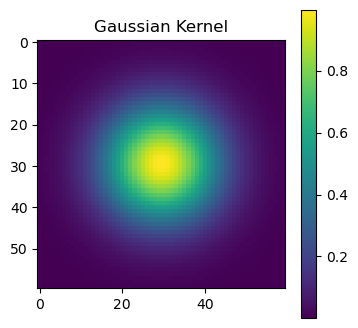

In [17]:
plt.figure(figsize=(4,4))
plt.imshow(kernel, cmap='viridis')
plt.title("Gaussian Kernel")
plt.colorbar()
plt.show()

In [19]:
def create_fire_signal(start, end):
    filter = (viirs_data.ACQ_DATE >= start.strftime("%Y-%m-%d")) & (viirs_data.ACQ_DATE < end.strftime("%Y-%m-%d"))
    filtered_viirs = viirs_data[filter]
    weights = filtered_viirs['FRP'].values
    x = filtered_viirs.geometry.x.values
    y = filtered_viirs.geometry.y.values
    
    # First do the analysis without weighting by FRP, to verify the fire locations with the above plot
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=list(combined_ds.MERRA2_CNN_Surface_PM25.shape[1:3]), range=[[y_min, y_max], [x_min, x_max]], weights=weights)

    # flip y axis to match the image (required debugging to see I needed to do this)
    heatmap = np.flipud(heatmap)
    
    # Perform convolution
    smoothed_heatmap = fftconvolve(heatmap, kernel, mode='same')
    
    # Set values lower than zero to zero
    smoothed_heatmap[smoothed_heatmap < 0] = 0.0

    return smoothed_heatmap
    
heatmap = create_fire_signal(periods[0][0], periods[0][1])

In [56]:
# data structure for each of our our prediction pairs
from collections import namedtuple

RawData = namedtuple("RawData", "viirs merra2 predicted date")
samples = {}

for start, end in periods:
    date_str = datetime.strftime(end, "%Y-%m-%d")
    viirs = create_fire_signal(start, end)
    merra2 = combined_ds.sel(time=end).MERRA2_CNN_Surface_PM25.values
    samples[date_str] = RawData(viirs=viirs, merra2=merra2, predicted=None, date=date_str)

### Run the convolution on each of the 2-week periods
- 27 periods
- each aligns with a PM2.5 sample date

In [45]:
# Create empty variable the same size as the PM2.5 data so we can populate it
combined_ds["fire_signal"] = (("time", "y", "x"), np.full(combined_ds["MERRA2_CNN_Surface_PM25"].shape, np.nan))

# Add metadata
combined_ds["fire_signal"].attrs = {
    "units": "Energy?",
    "description": "Viirs fire observations in the previous 2 weeks, scaled by a Gaussian kernel of bandwidth {0} meters".format(bandwidth),
}

# Note: we could work out the units more precisely, each viirs point is 375m * 375m, we have the units of the FRP, and we know the size of the grid we're binning to and the kernel we're using. It should end up being energy per raster cell, or equivalently energy density.

# go through the time points, create the fire signal, and populate the binned_variable
for start, end in periods:
    date_str = datetime.strftime(end, "%Y-%m-%d")
    viirs = create_fire_signal(start, end)

    if np.datetime64(end) not in combined_ds['time']:
        raise ValueError(f"Date {date_str} not found in MERRA-2 dataset")

    combined_ds["fire_signal"].loc[dict(time=np.datetime64(end))] = viirs

combined_ds

<xarray.Dataset> Size: 159MB
Dimensions:                  (time: 27, y: 350, x: 600)
Coordinates:
  * x                        (x) float64 5kB -1.497e+06 -1.492e+06 ... 1.498e+06
  * y                        (y) float64 3kB 9.959e+05 9.909e+05 ... -7.491e+05
  * time                     (time) datetime64[ns] 216B 2022-05-22T12:30:00 ....
    spatial_ref              int64 8B 0
Data variables:
    MERRA2_CNN_Surface_PM25  (time, y, x) float32 23MB 2.803 2.917 ... 10.38
    QFLAG                    (time, y, x) float64 45MB 2.0 2.0 2.0 ... 4.0 4.0
    fire_signal              (time, y, x) float64 45MB 2.954e-14 ... 2.236
    prediction               (time, y, x) float64 45MB nan nan nan ... nan nan
Attributes: (12/33)
    Comment:                           filename: MERRA2_HAQAST_CNN_L4_V1_2022...
    Filename:                          MERRA2_HAQAST_CNN_L4_V1_20220522.nc4
    Conventions:                       CF-1
    Institution:                       NASA Goddard Space Flight Center
    References:                        http://gmao.gsfc.nasa.gov ; https://do...
    Format:                            NetCDF-4/HDF-5
    ...                                ...
    RangeEndingDate:                   2022-05-22
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2023-04-21 04:24:38 GMT Hyrax-1.16.3 h...
    ProcessingLevel:                   4
    MapProjection:                     Geographic lat/lon. Datum: WGS-84

## Linear Regression

#### In our simple model, we'll predict PM2.5 at each grid point based solely on the VIIRS value at that grid point (independence assumption).

- note, no recognition of spatial effects

<img alt="" class="bh mq np c" width="235" height="176" loading="lazy" role="presentation" src="https://miro.medium.com/v2/resize:fit:470/1*-WrH6s43sOI4zVPMFyb4UA.png">

from https://towardsdatascience.com/building-linear-regression-least-squares-with-linear-algebra-2adf071dd5dd

### First, linearize the data

- $5 \cdot 10^6$ points!

In [21]:
# first, linearize the data
X = combined_ds["fire_signal"].values.flatten()
y = combined_ds["MERRA2_CNN_Surface_PM25"].values.flatten()

In [22]:
print(X.shape)
print(y.shape)

(5670000,)
(5670000,)


In [23]:
# convert to a 1d vector for linear regression
X = np.reshape(X, (len(X), 1))
y = np.reshape(y, (len(y), 1))

In [24]:
print(X.shape)
print(y.shape)

(5670000, 1)
(5670000, 1)


### Execute linear regression with scikit-learn

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

time the execution (on $5*10^6$ points!), just for fun..

In [27]:
import time
start_time = time.time()

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Execution time: 0.06 seconds


### How does the model perform?

In [28]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}  (min|max|mean = {y.min()} | {y.max()} | {y.mean()})")
print(f"R² Score: {r2}")

Mean Squared Error: 29.41396587869877  (min|max|mean = 0.0 | 197.2798309326172 | 3.2790627479553223)
R² Score: 0.07299203797362785


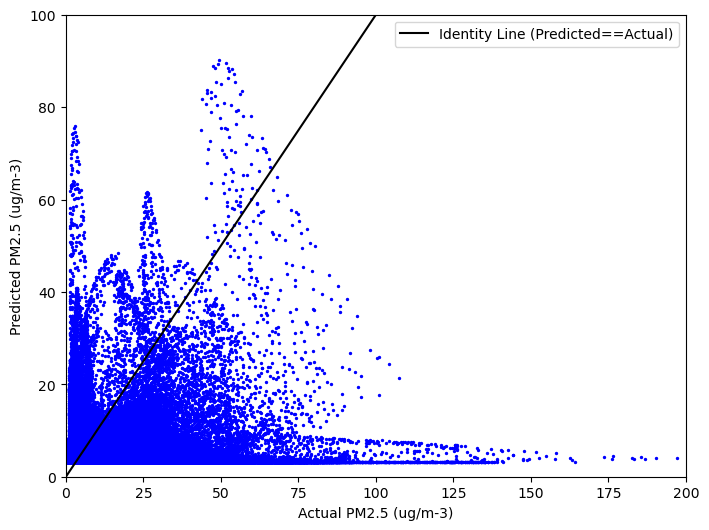

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(y_test, y_pred, color='blue', s=2)

x_line = np.linspace(0,100,100)
y_line = np.linspace(0,100,100)

ax.plot(x_line, y_line, color="black", linestyle="-", label="Identity Line (Predicted==Actual)")

ax.set_xlim(0, 200)
ax.set_ylim(0, 100)

ax.set_xlabel("Actual PM2.5 (ug/m-3)")
ax.set_ylabel("Predicted PM2.5 (ug/m-3)")

ax.legend()

## What does this mean?  
It's not very good:
- Mean Squared Error: This indicates that the average squared difference between the predicted value and the actual value is about 9x the mean value.  
- $R^2$: An $R^2$ of 0.0869 means that about 9% of the dependent variable (PM2.5 levels) is predictable from the independent variable (VIIRS fire intensity data). 
- There was a floor to the predictions of about 3 uq/m-3
- The "peaky" shapes in the regression scatterplot are interesting, and possibly suggest unexplored spatial relationships in the data, or single time-points where we have spatially correlated error

- Aside - this data plot makes it very hard to see how closely related the data is as we have 5 million points that can be very close together. An alternative is a 2d histogram. However the R^2 number is already quite informative on the quality of the model

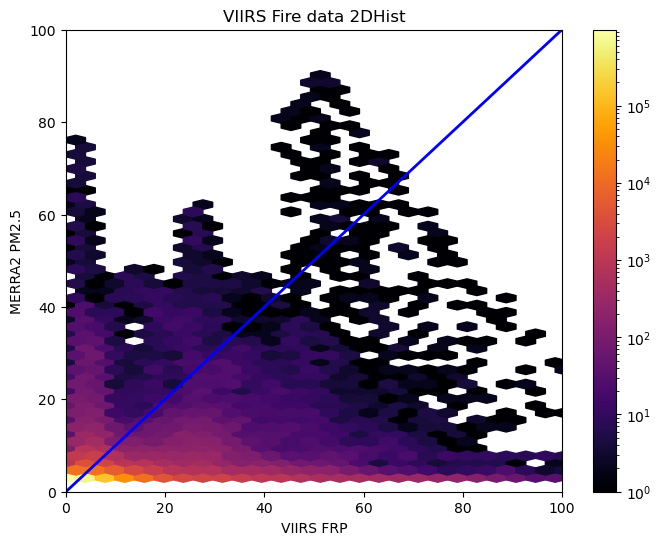

In [31]:
# create a 2d hist plot with a log scale on the bins
fig, ax = plt.subplots(figsize=(8,6))

hb = ax.hexbin(y_test, y_pred, gridsize=50, cmap='inferno', bins='log')

ax.set_xlabel('VIIRS FRP')
ax.set_ylabel('MERRA2 PM2.5')
ax.set_title('VIIRS Fire data 2DHist')
fig.colorbar(hb, ax=ax)

ax.plot(x_line, y_line, color="blue", linestyle="-", linewidth=2)

ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

## Plot of relationship between fire feature and PM2.5 over the test data set

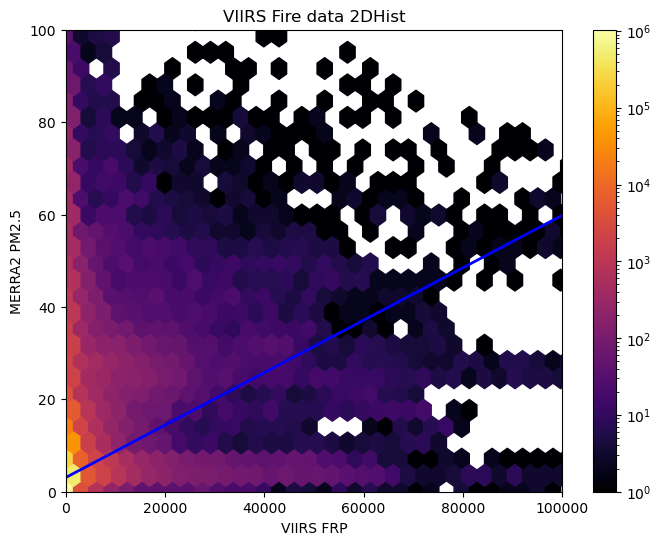

In [32]:
x_line = np.linspace(0,200000,100)
y_line = x_line * model.coef_[0] + model.intercept_

# create a 2d hist plot with a log scale on the bins
fig, ax = plt.subplots(figsize=(8,6))


hb = ax.hexbin(X_test.flatten(), y_test.flatten(), gridsize=50, cmap='inferno', bins='log')

ax.set_xlabel('VIIRS FRP')
ax.set_ylabel('MERRA2 PM2.5')
ax.set_title('VIIRS Fire data 2DHist')
fig.colorbar(hb, ax=ax)

ax.plot(x_line, y_line, color="blue", linestyle="-", linewidth=2)

ax.set_xlim(0, 100000)
ax.set_ylim(0, 100)
plt.show()

# Displaying the Prediction Results

#### We want to show each of the predictions that our model made and compare them to the actual values. 

In [33]:
# First, collect the model predictions for all 27 samples
y_full_pred = model.predict(X)    # technically, a concatenation of y_train and y_test

#### However, we linearized our data for regression...
#### We need to reshape it for mapping.

In [46]:
# reshape the predictions and match with dates

#chunk = 350 * 600  # the number of pixels in a single image
#predictions = {date: y_full_pred[(chunk * i):(chunk*(i+1))].reshape(350,600) for i, date in enumerate(samples)}

# Create empty variable the same size as the PM2.5 data so we can populate it
combined_ds["prediction"] = (("time", "y", "x"), np.full(combined_ds["MERRA2_CNN_Surface_PM25"].shape, np.nan))

# Add metadata
combined_ds["prediction"].attrs = {
    "units": "PM2.5",
    "description": "Prediction from simple linear regression of fire signal".format(bandwidth),
}

# go through the time points, create the fire signal, and populate the binned_variable
for start, end in periods:
    if np.datetime64(end) not in combined_ds['time']:
        raise ValueError(f"Date {end} not found in MERRA-2 dataset")

    pred = combined_ds["MERRA2_CNN_Surface_PM25"].loc[dict(time=np.datetime64(end))].values * model.coef_[0] + model.intercept_
    combined_ds["prediction"].loc[dict(time=np.datetime64(end))] = pred

combined_ds



<xarray.Dataset> Size: 159MB
Dimensions:                  (time: 27, y: 350, x: 600)
Coordinates:
  * x                        (x) float64 5kB -1.497e+06 -1.492e+06 ... 1.498e+06
  * y                        (y) float64 3kB 9.959e+05 9.909e+05 ... -7.491e+05
  * time                     (time) datetime64[ns] 216B 2022-05-22T12:30:00 ....
    spatial_ref              int64 8B 0
Data variables:
    MERRA2_CNN_Surface_PM25  (time, y, x) float32 23MB 2.803 2.917 ... 10.38
    QFLAG                    (time, y, x) float64 45MB 2.0 2.0 2.0 ... 4.0 4.0
    fire_signal              (time, y, x) float64 45MB 2.954e-14 ... 2.236
    prediction               (time, y, x) float64 45MB 3.09 3.09 ... 3.094 3.094
Attributes: (12/33)
    Comment:                           filename: MERRA2_HAQAST_CNN_L4_V1_2022...
    Filename:                          MERRA2_HAQAST_CNN_L4_V1_20220522.nc4
    Conventions:                       CF-1
    Institution:                       NASA Goddard Space Flight Center
    References:                        http://gmao.gsfc.nasa.gov ; https://do...
    Format:                            NetCDF-4/HDF-5
    ...                                ...
    RangeEndingDate:                   2022-05-22
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2023-04-21 04:24:38 GMT Hyrax-1.16.3 h...
    ProcessingLevel:                   4
    MapProjection:                     Geographic lat/lon. Datum: WGS-84

In [51]:
# setup the plot
num_samples = len(combined_ds['time'].values)
print(num_samples)

ax1 = list(range(num_samples))
ax2 = list(range(num_samples))
ax3 = list(range(num_samples))

27


In [138]:
# sort the dates
dates_sorted = sorted(list(samples.keys()))

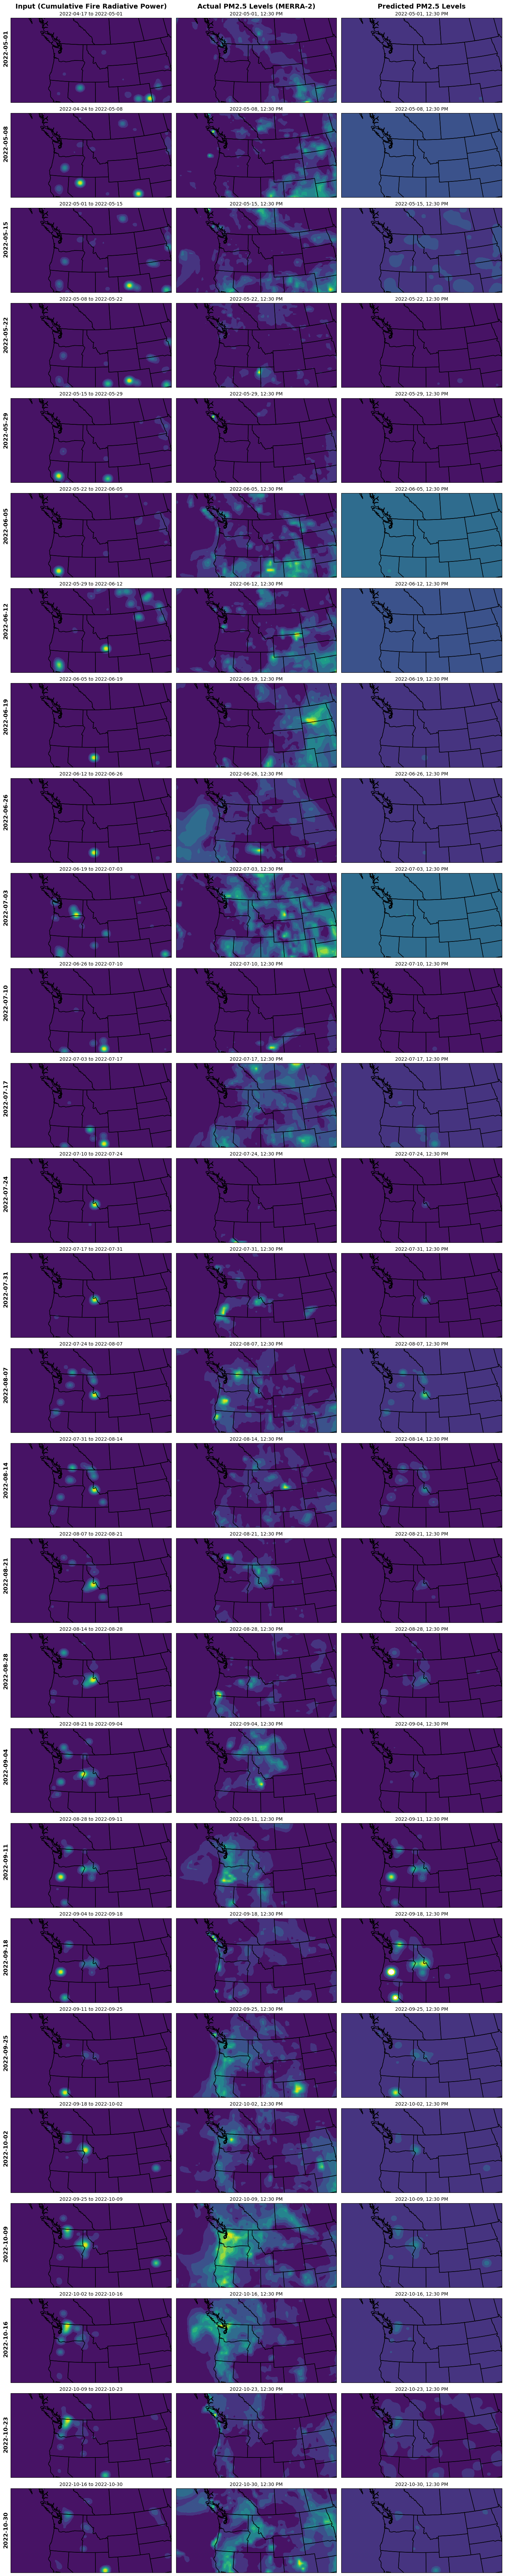

In [401]:
crs_proj4 = ccrs.AlbersEqualArea(
    central_longitude=-115, 
    central_latitude=45,    
    standard_parallels=(42, 48)
)

# Set up figure dimensions
aspect_ratio = (y_max - y_min) / (x_max - x_min)
fig = plt.figure(figsize=(25*aspect_ratio, 25*3))  # reduces distortion


for i in range(num_samples):

    prediction_date = combined_ds['time'].values[i]
    viirs_start = datetime.strftime(datetime.strptime(prediction_date, '%Y-%m-%d') - timedelta(weeks=2), '%Y-%m-%d')

    ax1[i] = fig.add_subplot(num_samples, 3, 1+3*i, projection=crs_proj4)
    ax1[i].set_extent([x_min, x_max, y_min, y_max], crs=crs_proj4) # CONUS extent
    ax1[i].coastlines(resolution='50m')
    ax1[i].add_feature(cfeature.BORDERS)
    ax1[i].add_feature(cfeature.STATES)
    
    ax1[i].set_yticklabels("fsfa")

    if i == 0:
        ax1[i].set_title(f"Input (Cumulative Fire Radiative Power)", fontsize=14, fontweight='bold', y=1.08)
    ax1[i].text(x=0.5, y = 1.02, s = f"{viirs_start} to {prediction_date}", transform=ax1[i].transAxes, 
            ha='center', va='bottom', fontsize=10)
    
    # Set up filled and line contours
    # 10 levels from 0 to max
    max_val = samples[prediction_date].viirs.max()
    levels = np.linspace(0, max_val, 11)

    filled_c1 = ax1[i].contourf(combined_ds.x, combined_ds.y, samples[prediction_date].viirs, levels=levels, 
                        transform=crs_proj4)
    ax1[i].set_ylabel(f"{dates_sorted[i]}", fontsize=10, labelpad=10)
    # plot the MERRA2 data

    #heatmap_merra2 = combined_ds.sel(time=periods[0][1]).MERRA2_CNN_Surface_PM25.values

    # Lat/lon grid lines
    #ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

    ax2[i] = fig.add_subplot(num_samples, 3, 2+3*i,  projection=crs_proj4)
    ax2[i].set_extent([x_min, x_max, y_min, y_max], crs=crs_proj4) # CONUS extent
    ax2[i].coastlines(resolution='50m')
    ax2[i].add_feature(cfeature.BORDERS)
    ax2[i].add_feature(cfeature.STATES)

    # Set up filled and line contours
    # 10 levels from 0 to max
    max_val = samples[prediction_date].merra2.max()
    levels = np.linspace(0, max_val, 11)

    filled_c2 = ax2[i].contourf(combined_ds.x, combined_ds.y, samples[prediction_date].merra2, levels=levels, 
                        transform=crs_proj4)

    # Lat/lon grid lines
    #ax2.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
    if i== 0:
        ax2[i].set_title(f"Actual PM2.5 Levels (MERRA-2)", fontsize=14, fontweight='bold', y=1.08)
    ax2[i].text(x=0.5, y = 1.02, s = f"{prediction_date}, 12:30 PM", transform=ax2[i].transAxes, 
            ha='center', va='bottom', fontsize=10)
    
    # get the predicted data

    ax3[i] = fig.add_subplot(num_samples, 3, 3+3*i,  projection=crs_proj4)
    ax3[i].set_extent([x_min, x_max, y_min, y_max], crs=crs_proj4) # CONUS extent
    ax3[i].coastlines(resolution='50m')
    ax3[i].add_feature(cfeature.BORDERS)
    ax3[i].add_feature(cfeature.STATES)

    # plot with same scale as ax2 (for comparison)

    filled_c3 = ax3[i].contourf(combined_ds.x, combined_ds.y, predictions[prediction_date], levels=levels, 
                        transform=crs_proj4)

    # Lat/lon grid lines
    #ax2.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
    if i== 0:
        ax3[i].set_title(f"Predicted PM2.5 Levels", fontsize=14, fontweight='bold', y=1.08)
    ax3[i].text(x=0.5, y = 1.02, s = f"{prediction_date}, 12:30 PM", transform=ax3[i].transAxes, 
            ha='center', va='bottom', fontsize=10)
    
    ax1[i].set_aspect("auto")
    ax2[i].set_aspect("auto")
    ax3[i].set_aspect("auto")
    
    fig.text(
        x= 0,  # X-position (slightly left of the subplots)
        y= 1 - (i + 0.5) / num_samples,  
        fontsize=12,  
        fontweight='bold',  
        ha='center',  #
        va='center', 
        rotation=90  
    )
    

#plt.subplots_adjust(hspace=0, wspace=0)  
#plt.subplots_adjust(left=0.5)
#plt.figure(constrained_layout=True)
plt.tight_layout(pad=1)

plt.show()


### How can we improve the coloring of these plots?
- currently, the scale for each plot is based on the range of its own data (split into 10 equal-sized bins)
- however, the range of value varies considerably
- would it look better if we used just two scales - one each for each kind of data (Fire Intensity, PM2.5)

Text(0.5, 1.05, 'Distribution of Values for VIIRS, MERRA2, and Predictions')

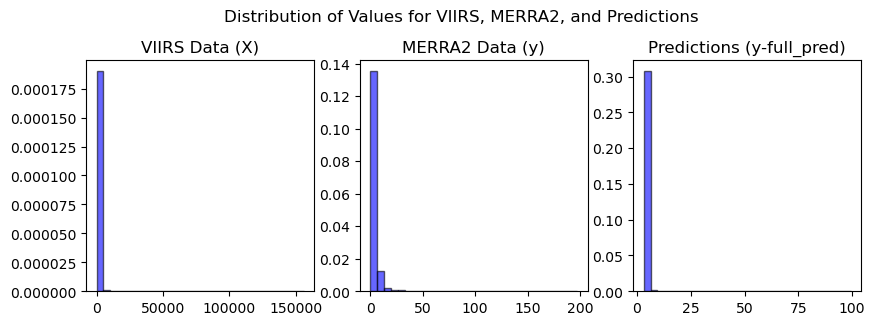

In [139]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(X.ravel(), bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')
ax[0].set_title("VIIRS Data (X)")
ax[1].hist(y.ravel(), bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')
ax[1].set_title("MERRA2 Data (y)")
ax[2].hist(y_full_pred.ravel(), bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')
ax[2].set_title("Predictions (y-full_pred)")

fig.suptitle("Distribution of Values for VIIRS, MERRA2, and Predictions", y=1.05)



#### The distributions for each appear to have extremely long tails...

In [141]:
print(f"X: {np.percentile(X.flatten(), [25, 50, 75, 95, 99, 100])}")
print(f"y: {np.percentile(y.flatten(), [25, 50, 75, 95, 99, 100])}")
print(f"y_full_pred: {np.percentile(y_full_pred.flatten(), [25, 50, 75, 95, 99, 100])}")


X: [5.85508330e-03 5.44194043e+00 4.31719635e+01 8.28093855e+02
 6.54301678e+03 1.55971633e+05]
y: [  0.69570203   1.83945251   4.00027323   9.62974434  27.52798326
 197.27983093]
y_full_pred: [ 3.07410912  3.07746838  3.10078387  3.58583099  7.11740139 99.45769825]


#### The "long tails" are confirmed above:
- For X, there is a $10^2$ difference between 99th and 100th percentile
- For y and y_pred_full, there is a $10^1$ difference between 99th and 100th percentile


#### Let's adjust the upper-range of our visualization (trial and error)

In [142]:
viirs_max = np.percentile(X.flatten(), [99.5])[0]
pm25_max = np.percentile(y.flatten(), [99.5])[0]

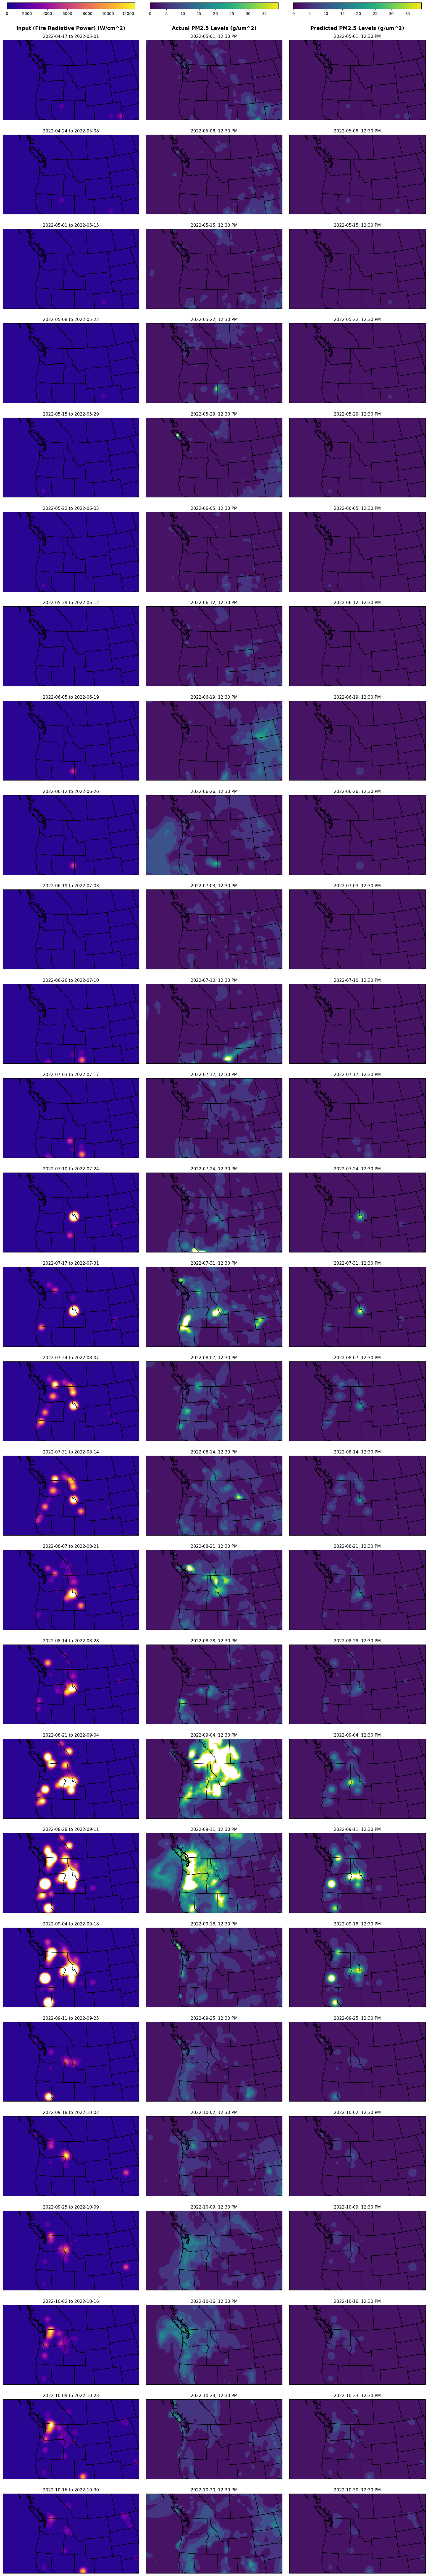

In [190]:
# Set up figure 
aspect_ratio = (y_max - y_min) / (x_max - x_min)
fig = plt.figure(figsize=(35*aspect_ratio, 35*3*1.15))   # extend width because of extra height from 1st two rows

levels_viirs = np.linspace(0, viirs_max, 11)
levels_pm25 = np.linspace(0, pm25_max, 11)

# num rows = samples + 2 (1st two rows for colorbar and spacing)
gs = gridspec.GridSpec(num_samples + 2, 3, height_ratios=[.08] + [0.02] + [1] * num_samples, hspace=0.2, wspace=0)

crs_proj4 = ccrs.AlbersEqualArea(central_longitude=-115, central_latitude=45, standard_parallels=(42, 48))

# colorbar in first row
for col in range(3):
    ax_cb = fig.add_subplot(gs[0, col])
    
    levels = levels_viirs if col == 0 else levels_pm25
    cmap = plt.cm.plasma if col == 0 else plt.cm.viridis
    norm = plt.Normalize(vmin=levels[0], vmax=levels[-1])
    #cbar.set_label(title, fontsize=10, fontweight='bold')
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cb, orientation='horizontal')
    
    box = ax_cb.get_position()
    cbar_width_ratio = 0.85  # adjust width of colorbars
    ax_cb.set_position([
        box.x0 + (1 - cbar_width_ratio) / 2 * box.width,  # center horiz
        box.y0,
        cbar_width_ratio * box.width,  # width
        box.height
    ])

# subplots for the data
for i in range(num_samples):

    prediction_date = dates_sorted[i]
    viirs_start = datetime.strftime(datetime.strptime(prediction_date, '%Y-%m-%d') - timedelta(weeks=2), '%Y-%m-%d')

    for col, dataset, levels, cmap, title in zip(
        range(3), 
        ["viirs", "merra2", predictions[prediction_date]], 
        [levels_viirs, levels_pm25, levels_pm25], 
        [plt.cm.plasma, plt.cm.viridis, plt.cm.viridis],
        ["Input (Fire Radiative Power) (W/cm^2)", "Actual PM2.5 Levels (g/um^2)", "Predicted PM2.5 Levels (g/um^2)"]
    ):
        ax = fig.add_subplot(gs[i + 2, col], projection=crs_proj4)
        ax.set_extent([x_min, x_max, y_min, y_max], crs=crs_proj4)
        ax.coastlines(resolution='50m')
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES)
        
        # Plot data
        data = getattr(samples[prediction_date], dataset) if col < 2 else dataset
        filled = ax.contourf(combined_ds['x'], combined_ds['y'], data, levels=levels, cmap=cmap, transform=crs_proj4)
        
        # Add title and labels for each column
        if i == 0:
            ax.set_title(title, fontsize=13, y=1.105, fontweight='bold')

        ax.text(
            x=0.5, y=1.02, 
            s=f"{viirs_start} to {prediction_date}" if col == 0 else f"{prediction_date}, 12:30 PM", 
            transform=ax.transAxes, 
            ha='center', va='bottom', fontsize=11
        )

        # critical for 
        #ax.set_aspect("auto")

#plt.tight_layout()
plt.show()

# Discussion

Clearly, our model does not produce very accurate predictions. Only 8% of the PM2.5 levels are explainable by the the cumulative VIIRS data ($R^2$). However, the model is extremeley naive and the results hint at numerous avenues for improving our predictions. 

First, we might add new input features along the spatial dimension. The place to start would probably be meteorological variables (wind, humidity, etc.) and existing VIIRS data at different resolutions (i.e. the raw point data). It also seems promising to incorporate PM2.5 data as inputs to our model, perhaps for a period of time close before our prediction target date. 

Second, it seems likely we could improved model accuracy by extending our prediction target along the temporal dimension. Instead of predicting PM2.5 at precisely 12:30 pm on Sundays, we could predict the average PM2.5 value for an entire day (or some other time period). It would also be interesting to see if there are differences in predicting maximum PM2.5 versuss average levels.

In [59]:
from IPython.display import Image

# Paper 1

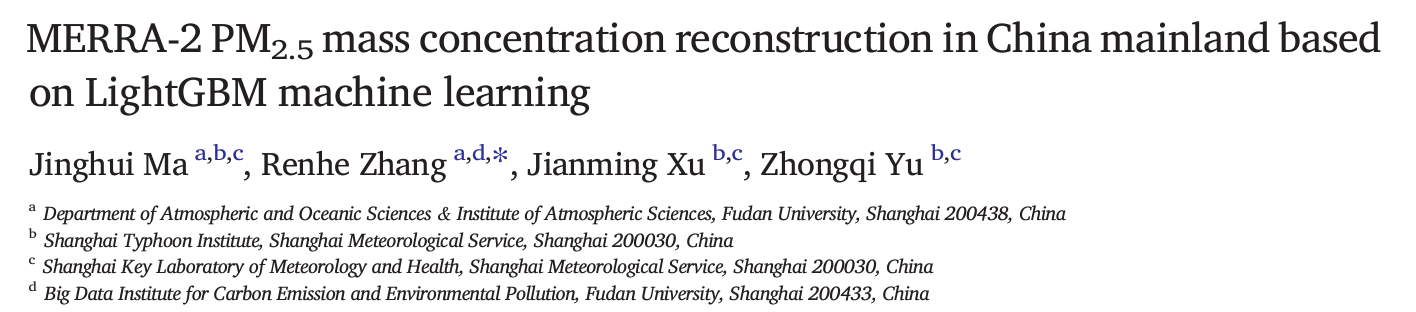

In [62]:
Image("Snaps/Ma_Title.png")

https://www.sciencedirect.com/science/article/pii/S0048969722014565

This paper describes a method of improving the accuracy of PM2.5 estimates in mainland China by augmenting MERRA-2 data with additional meteoroligcal variables. Recent research suggests that MERRA-2 underrates PM2.5 across China, particularly in the Winter and Autumm. The study added fifty-three meteorological factors available from the ERA-5 reanalysis datasets. Each of these datasets was regridded to a 0.5x0.5 degree raster grid, using Krigina and nearest neighbor interpolation. From here, the authors applied a Ligh Gradient Boosting Machine (LGBM) model, which is a decision tree model. Training was conducted on data from 2014 to 2018, and 2019 data was used for testing. Training performance varied significantly, performing much worse in the higher elevation areas to west and north. Generally, this method improved predictive performance over MERRA-2 alone, with significant spatial and temporal variations in performance. Overall, this was a well written and laid-out study that provides a good template for reanalysis studies that utilize machine learning techniques.

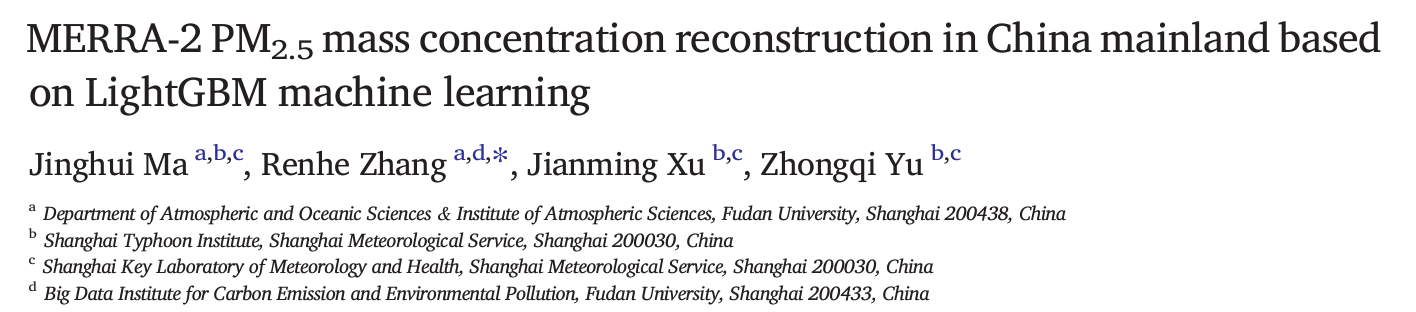

In [63]:
Image("Snaps/Ma_Graphs.png")

## Paper 2

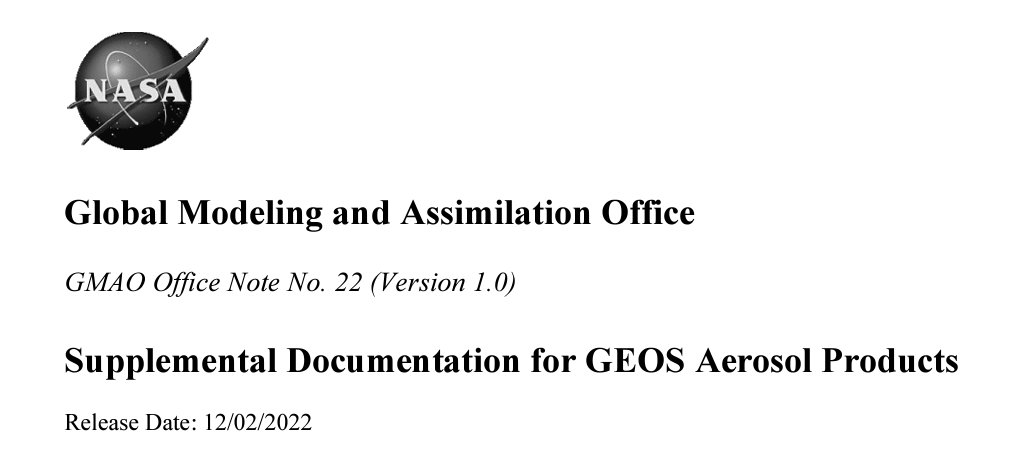

In [64]:
Image("Snaps/GMAO_Title.png")

https://ntrs.nasa.gov/api/citations/20220017880/downloads/Office%20Notes%20%2322%20-%20geosaerosoldocumentation%20-%20v2.pdf

This paper provides detailed view of the Aerosol estimates in MERRA-2 data. It is a primary reference in MERRA-2 documentation. PM2.5 is not measured directly by MERRA-2. Rather, it's a variable that is calculated based on estimates of five aerosol species that are measured directly in MERRA-2: black carbon, dust, organic carbon, sea salt, and sulfate. This paper describes a method for combining these measures into a single generalized PM2.5 volumetric estimate. However, it turns out that the density of each of the species changes with ambient relative hudidity. It seems that we would either have to estiamte RH, or obtain this data from other sources. We found a different data source that has already done this reanalysis, with the assumption that RH=0. Interestingly, this new data source comes with a matching set of error estimate for every grid point, suggesting that accuracy is not high.

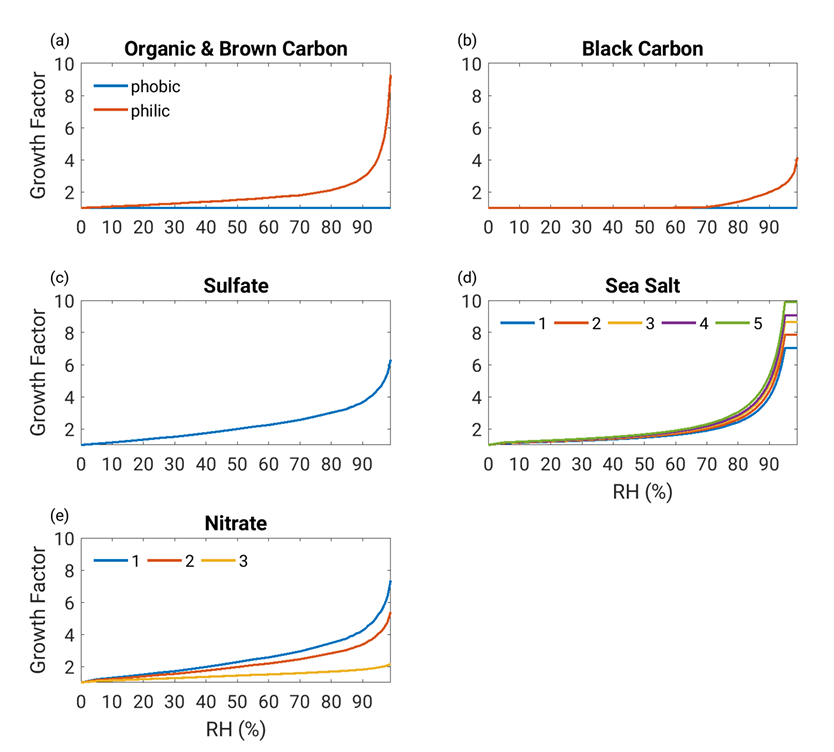

In [65]:
Image("Snaps/GMAO_Graphs.png")

# Paper 3

https://acdisc.gesdisc.eosdis.nasa.gov/data/HAQAST/MERRA2_CNN_HAQAST_PM25.1/doc/README_MERRA2_CNN_HAQAST_PM25_V1.pdf

This is a readme document on the MERRA-2 CNN_HAQAST Bias correction, where they trained a model to calibrate the merra pm2.5 data against ground observations. This is the dataset that we made use of above.

This paper makes use of one of the plot types we used for assessing our model predictions. Interestingly, you can see the original data has very similar qualities to the model that we produced, with large amounts of data falling close to one axis or the other.




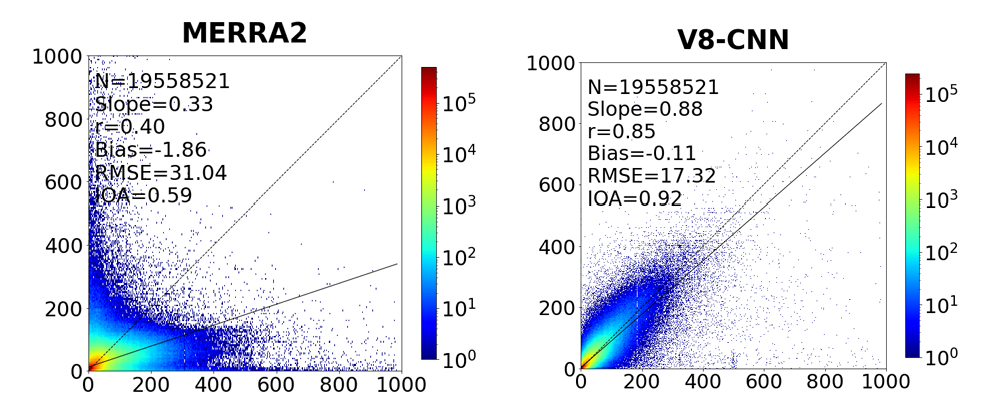

In [57]:
Image("Snaps/MERRA_README.png")

# Paper 4

https://arxiv.org/pdf/2312.15796

This paper covers one of Deepminds models targetting weather prediction called GenCast. Their main focus in this paper is to extend previous work in their Graphcast model which minimised RMSE, and thus produced simulations that were smoothed. In this paper they produce ensemble predictions that give more realistic scenarios that have similar micro behavior as observed in the realworld, and can also be used to give distribution predictions.

Our ambitions in this assignment are far away from this of course, but it is good to think about the different types of outputs you may be encouraging a model to produce.

In the snip below you can see the display of multiple samples from their generative weather model, compared to ground truth and ensemble means (and previous model). This displays the benefit of an approach like this quite cleanly.

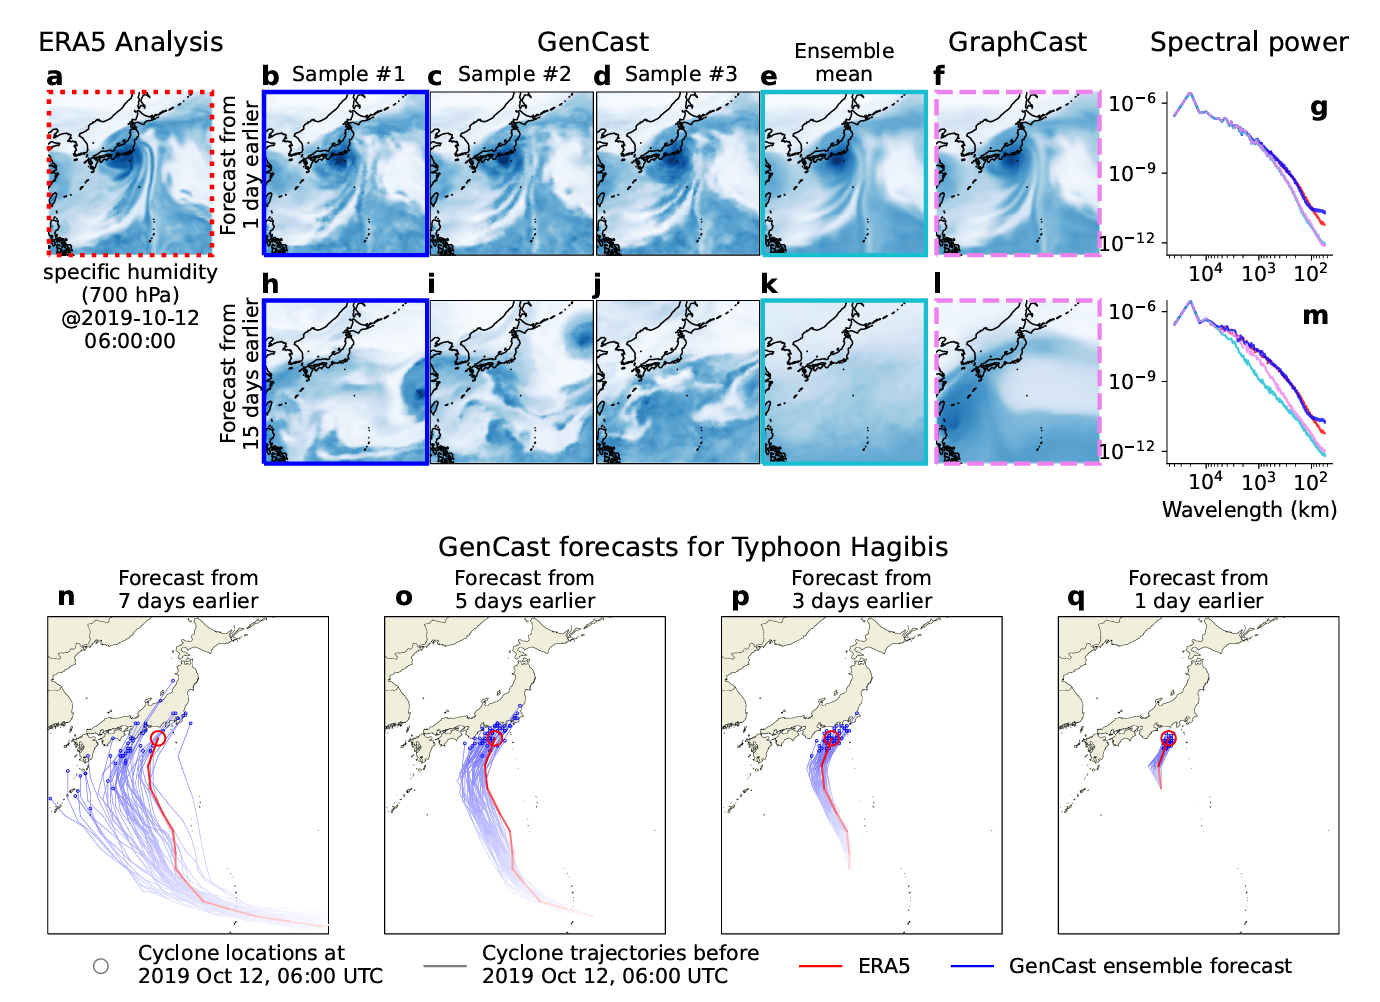

In [58]:
Image("Snaps/GenCast.png")

In [66]:
!jupyter nbconvert --to html Iteration4.ipynb

[NbConvertApp] Converting notebook Iteration4.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 14 image(s).
[NbConvertApp] Writing 9766911 bytes to Iteration4.html
